In [ ]:
!pip install tensorflow_text

In [ ]:
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow as tf
import pandas as pd

#Reading First Dataset

In [ ]:
df=pd.read_csv('/content/spam.csv', encoding = "ISO-8859-1")
df.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'],inplace=True)
df = df.rename(columns ={'v1':'label','v2':'text'})
df.head(5)

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
dh = pd.DataFrame({'data': [ 653, 4516]},
                  index=['Spam', 'Not Spam'])
dh.plot.pie(y='data', figsize=(5, 5),autopct='%1.0f%%')

<Axes: >

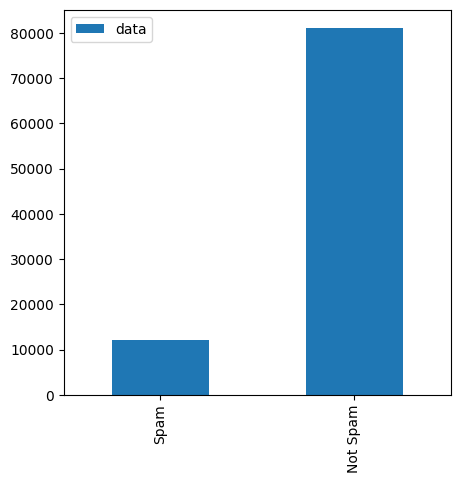

In [ ]:
dg = pd.DataFrame({'data': [ 2*6053, 2*40516]},
                  index=['Spam', 'Not Spam'])
dg.plot.bar(y='data', figsize=(5, 5))

<Axes: >

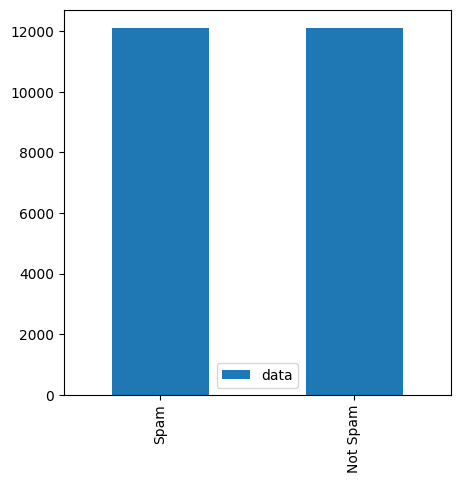

In [ ]:
dg = pd.DataFrame({'data': [ 2*6053, 2*6053]},
                  index=['Spam', 'Not Spam'])
dg.plot.bar(y='data', figsize=(5, 5))

In [ ]:
#balancing
df_ham=df[df["label"]=="ham"].sample(len(df[df["label"]=="spam"]))
df_spam=df[df["label"]=="spam"]
df_new=pd.concat([df_ham,df_spam])
df_new

,label,text
574,ham,Nope i waiting in sch 4 daddy...
4042,ham,I am literally in bed and have been up for lik...
2575,ham,Now thats going to ruin your thesis!
958,ham,My sort code is and acc no is . The bank is n...
1076,ham,Where can download clear movies. Dvd copies.
...,...,...
5537,spam,Want explicit SEX in 30 secs? Ring 02073162414...
5540,spam,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547,spam,Had your contract mobile 11 Mnths? Latest Moto...
5566,spam,REMINDER FROM O2: To get 2.50 pounds free call...


#Reading another datasets

In [ ]:
#new dataset considering this dataset as well
data_new=pd.read_csv('/content/emails.csv')
list1=data_new["text"].tolist()
list2=[" ".join(item.split(" ")[1:])for item in list1]
data_new = pd.concat([data_new[["text","spam"]], pd.DataFrame(list2, columns=["new_text"])], axis=1)

ll = data_new[data_new["spam"]=="1"].count()
df_NS=data_new[data_new["spam"]=="0"].sample(ll[0])
df_S=data_new[data_new["spam"]=="1"]
df_new=pd.concat([df_S,df_NS])
for i in range(4):
  df_new = df_new.sample(len(df_new))
df_new["spam"]= df_new["spam"].astype(int)

,text,spam,new_text
704,Subject: low price software http : / / neonat...,1,low price software http : / / neonate . setup...
2475,Subject: re : f / u to dr . kaminski @ enron f...,0,re : f / u to dr . kaminski @ enron from iris ...
5027,Subject: re : mba polish speakers does he kno...,0,re : mba polish speakers does he know any of ...
4885,Subject: re : action learning project and enro...,0,re : action learning project and enron tour h...
5566,Subject: re : mgmt 656 ( rice university ) th...,0,re : mgmt 656 ( rice university ) this list i...
...,...,...,...
4799,"Subject: re : workshop helyette , i shall be...",0,"re : workshop helyette , i shall be glad to ..."
3357,"Subject: aiesec vince , my name is shelly jo...",0,"aiesec vince , my name is shelly jones , i a..."
585,Subject: failure notice hi . this is the qmai...,1,failure notice hi . this is the qmail - send ...
1459,Subject: uk rpi model hi zimin ! please find...,0,uk rpi model hi zimin ! please find attached...


In [ ]:
#split data to train and test
from sklearn.model_selection import train_test_split
X_train,X_test, y_train, y_test = train_test_split(df_new['new_text'],df_new['spam'],test_size=0.2)

#Model: Bert model

In [ ]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [ ]:
# Testing one sample sentence using bert to the the shape of output
sample_sentence1 =['please send me a money', 'please add this link to connect to the bank for sending money','the weather is nice']
def output_bert(input):
  return bert_encoder(bert_preprocess(input))['pooled_output']
output_bert(sample_sentence1)

<tf.Tensor: shape=(3, 768), dtype=float32, numpy=
array([[-0.71250397, -0.15150864,  0.7730772 , ...,  0.6257716 ,
        -0.5277045 ,  0.80240107],
       [-0.70500344, -0.27077198,  0.24238788, ...,  0.20055047,
        -0.60361606,  0.7437381 ],
       [-0.84708345, -0.26582313, -0.02207363, ..., -0.14459969,
        -0.6319466 ,  0.9162428 ]], dtype=float32)>

In [ ]:
# Example of Cosine similarity of previous sentences
from sklearn.metrics.pairwise import cosine_similarity
c=output_bert(sample_sentence1)
cosine_similarity(c[0].numpy().reshape(1, -1),c[1].numpy().reshape(1, -1)),cosine_similarity(c[0].numpy().reshape(1, -1),c[2].numpy().reshape(1, -1))

(array([[0.9060165]], dtype=float32), array([[0.80221236]], dtype=float32))

In [ ]:
from tensorflow.keras.layers import Dense, Input, Dropout
import tensorflow as tf

inputs= Input(shape=(),dtype=tf.string)
x=output_bert(inputs)
x=Dropout(0.2)(x)
x=Dense(1,activation='sigmoid')(x)
model=tf.keras.models.Model(inputs=inputs, outputs=x)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_mask': (None, 128)   0         ['input_1[0][0]']             
                             , 'input_word_ids': (None,                                           
                              128),                                                               
                              'input_type_ids': (None,                                            
                             128)}                                                                
                                                                                              

In [ ]:
# The final epochh that I ran is 100
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),metrics=['accuracy'])
history=model.fit(X_train[:int(len(X_train)*0.8)],y_train[:int(len(y_train)*0.8)]
                  ,validation_data= (X_train[int(len(X_train)*0.8):],y_train[int(len(y_train)*0.8):])
                  ,epochs=10)

Epoch 1/10
55/55 [==============================] - 193s 3s/step - loss: 0.6776 - accuracy: 0.5746 - val_loss: 0.6024 - val_accuracy: 0.7306
Epoch 2/10
55/55 [==============================] - 181s 3s/step - loss: 0.5946 - accuracy: 0.6970 - val_loss: 0.5423 - val_accuracy: 0.7717
Epoch 3/10
55/55 [==============================] - 181s 3s/step - loss: 0.5437 - accuracy: 0.7410 - val_loss: 0.5135 - val_accuracy: 0.7854
Epoch 4/10
55/55 [==============================] - 176s 3s/step - loss: 0.5122 - accuracy: 0.7724 - val_loss: 0.4738 - val_accuracy: 0.8265
Epoch 5/10
55/55 [==============================] - 179s 3s/step - loss: 0.4789 - accuracy: 0.8027 - val_loss: 0.4550 - val_accuracy: 0.8196
Epoch 6/10
55/55 [==============================] - 180s 3s/step - loss: 0.4670 - accuracy: 0.7930 - val_loss: 0.4328 - val_accuracy: 0.8630
Epoch 7/10
55/55 [==============================] - 181s 3s/step - loss: 0.4387 - accuracy: 0.8153 - val_loss: 0.4135 - val_accuracy: 0.8584
Epoch 8/10
55

#Accuracy Variation

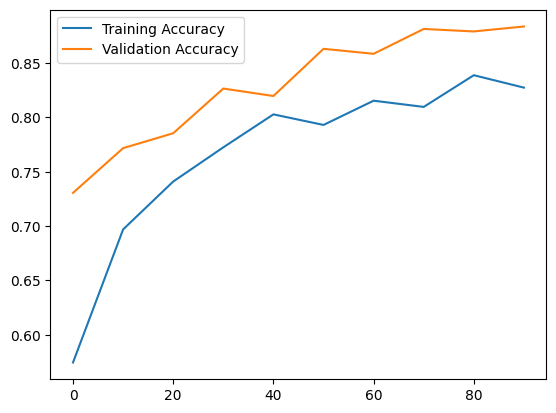

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
plt.plot(np.arange(len(history.history["accuracy"])),history.history["accuracy"],label = "Training Accuracy")
plt.plot(np.arange(len(history.history["val_accuracy"])),history.history["val_accuracy"], label = "Validation Accuracy")
plt.legend()

In [ ]:
#Prediction on the X_test
y_pred=model.predict(X_test)

10/10 [==============================] - 33s 3s/step


#Classification Report

In [ ]:
# Checking some kind of metrics
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred.round()))

              precision    recall  f1-score   support

           0       0.81      0.93      0.86       144
           1       0.92      0.79      0.85       155

    accuracy                           0.86       299
   macro avg       0.87      0.86      0.86       299
weighted avg       0.87      0.86      0.86       299



#Confusion Matrix

<Axes: >

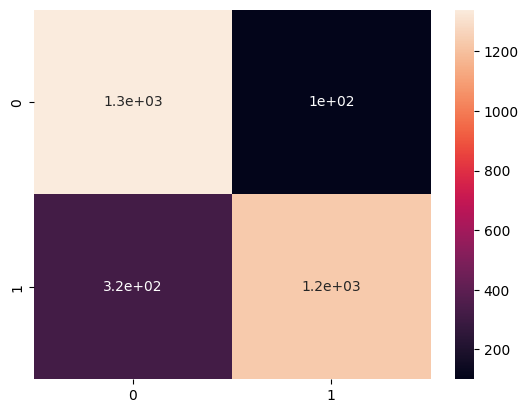

In [ ]:
#Confusion Matrix
import seaborn as sn
sn.heatmap(confusion_matrix(y_test,y_pred.round()),annot=True)

#Second Model LSTM

In [ ]:
from tensorflow.keras.layers import Embedding

In [ ]:
#Paraeter of this model
MAX_SEQUENCE_LENGTH = 40
EMBEDDING_DIM = 300
#MAX_SEQUENCE_LENGTH = 30

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
vocab_size = len(word_index)+1

In [ ]:
x_new=pad_sequences(tokenizer.texts_to_sequences(X_train),maxlen = MAX_SEQUENCE_LENGTH)

In [ ]:
x_new.shape

(1195, 40)

In [ ]:
y_train.shape

(1195,)

In [ ]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D

In [ ]:
Embedding=tf.keras.layers.Embedding(input_dim = vocab_size,
                          output_dim = EMBEDDING_DIM)


inputs = Input(shape=(MAX_SEQUENCE_LENGTH,))
print(inputs.shape)
x=Embedding(inputs)
x = SpatialDropout1D(0.2)(x)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(10, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(10, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.models.Model(inputs, outputs)
model.summary()

(None, 40)
Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 40)]              0         
                                                                 
 embedding_6 (Embedding)     (None, 40, 300)           1245900   
                                                                 
 spatial_dropout1d_6 (Spati  (None, 40, 300)           0         
 alDropout1D)                                                    
                                                                 
 conv1d_6 (Conv1D)           (None, 36, 64)            96064     
                                                                 
 bidirectional_6 (Bidirecti  (None, 128)               66048     
 onal)                                                           
                                                                 
 dense_20 (Dense)            (None, 10)         

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
history=model.fit(x_new[:int(len(x_new)*0.8)],y_train[:int(len(y_train)*0.8)]
                  ,validation_data= (x_new[int(len(x_new)*0.8):],y_train[int(len(y_train)*0.8):])
                  ,epochs=100)

In [ ]:
ac=[i for i in history.history["accuracy"]]
val_ac=[i for i in history.history["val_accuracy"]]

#Accuracy vs. Epoch

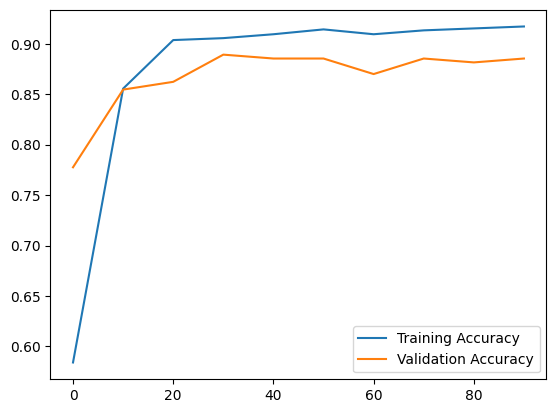

In [ ]:
plt.plot(np.arange(len(ac))*10,ac,label = "Training Accuracy" )
plt.plot(np.arange(len(val_ac))*10,val_ac,label = "Validation Accuracy")
plt.legend()

#Classification Report

In [ ]:
from sklearn.metrics import classification_report
x_test_new =pad_sequences(tokenizer.texts_to_sequences(X_test),maxlen = MAX_SEQUENCE_LENGTH)
y_pred=model.predict(x_test_new)
print(classification_report(y_test,y_pred.round()))

10/10 [==============================] - 1s 9ms/step
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       151
           1       0.97      0.93      0.95       148

    accuracy                           0.95       299
   macro avg       0.95      0.95      0.95       299
weighted avg       0.95      0.95      0.95       299



#Confusion Matrix LSTM

<Axes: >

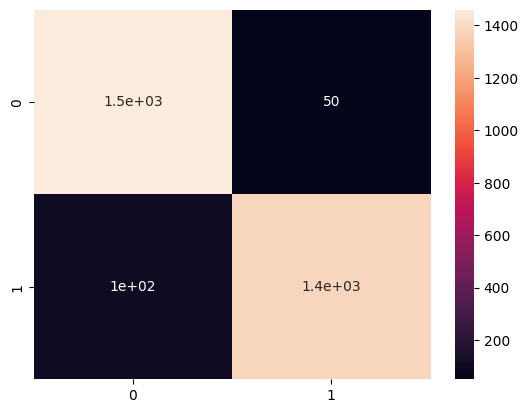

In [ ]:
sn.heatmap(confusion_matrix(y_test,y_pred.round())*10,annot=True)

In [ ]:
df2=pd.DataFrame({"Number of Data":[12000, 18000, 24000],
                  "Accuracy":[89.4, 90.2, 90.4]})

#Accurayc vs Number of data

<Axes: xlabel='Number of Data'>

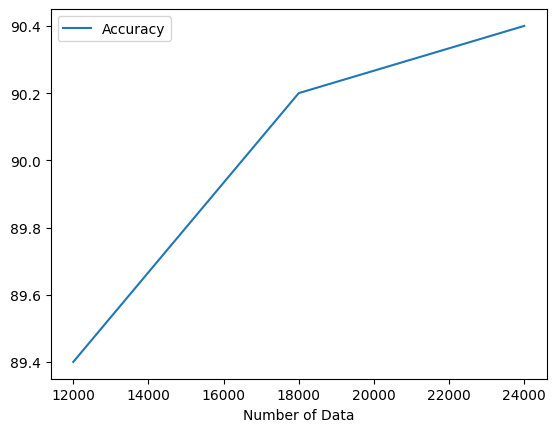

In [ ]:

df2.plot(x="Number of Data",y="Accuracy")

#Removing outlier from dataset using Isolation Forest


In [ ]:
#Removing outlier from dataset
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split

# Assuming 'text' is the column containing email text and 'label' is the column indicating spam or not
# df = pd.read_csv('your_dataset.csv')

# Step 1: Split the data into training and testing sets
train_data, test_data, train_labels, test_labels = X_train,X_test, y_train, y_test

# Step 2: Convert text data to numerical features using TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=5000)  # You can adjust max_features based on your dataset size
train_features = vectorizer.fit_transform(train_data)
test_features = vectorizer.transform(test_data)

# Step 3: Train an Isolation Forest model to identify outliers
iso_forest = IsolationForest(contamination=0.05, random_state=42)  # You can adjust the contamination parameter
iso_forest.fit(train_features)

# Step 4: Predict outliers in the test set
outlier_predictions = iso_forest.predict(test_features)

# Step 5: Identify outliers and remove them from the dataset
outliers_mask = (outlier_predictions == -1)
cleaned_test_data = test_data[~outliers_mask]
cleaned_test_labels = test_labels[~outliers_mask]

# Optional: Print information about the removed outliers
removed_outliers = test_data[outliers_mask]
print(f"Number of outliers removed: {len(removed_outliers)}")
print(removed_outliers)

# Now, 'cleaned_test_data' and 'cleaned_test_labels' can be used for evaluation or further analysis


# Step 4-2: Predict outliers in the test set
outlier_predictions = iso_forest.predict(train_features)

# Step 5-2: Identify outliers and remove them from the dataset
outliers_mask = (outlier_predictions == -1)
cleaned_train_data = train_data[~outliers_mask]
cleaned_train_labels = train_labels[~outliers_mask]

# Optional-2: Print information about the removed outliers
removed_outliers = train_data[outliers_mask]
print(f"Number of outliers removed: {len(removed_outliers)}")
print(removed_outliers)

# Now, 'cleaned_test_data' and 'cleaned_test_labels' can be used for evaluation or further analysis


Number of outliers removed: 23
192     industry forum # 136  the industry forum  minu...
51      grab this quick triple at its low  homeland se...
13      wall street phenomenon reaps rewards  small - ...
511     wallstreet pulse  good day to all broker ' s ,...
4855    re : enroncredit . com  alex worked with jiten...
2166    visit with vince kaminski on may 4 th  carol :...
4053    alliance info alert  dear generation / power m...
1482    videoconferencing picture clears up  network w...
701     this stock rumored to fly  special situation a...
461     a better investment than the stock market .  a...
151     industry giants can ' t match this opportunity...
240     atft . pk has announced the acquisition betwee...
563     estate of your late relative  barrister usman ...
1168    grand - slam stox  momentum alert issued for j...
1178    stock 2 watch  pop 3 media corp ( popt )  a co...
992     i do not have anything against you  ourref : c...
422     ever have a sm 4 ll spock take of

In [ ]:
# The final Epoch I ran this is 100 -Only RUN FOR BART MODEL
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy'])
history = model.fit(cleaned_train_data[:int(len(cleaned_train_data)*0.8)],cleaned_train_labels[:int(len(cleaned_train_labels)*0.8)]
                  ,validation_data= (cleaned_train_data[int(len(cleaned_train_data)*0.8):],cleaned_train_labels[int(len(cleaned_train_labels)*0.8):])
                  ,epochs=30)

Epoch 1/30
52/52 [==============================] - 229s 4s/step - loss: 0.6589 - accuracy: 0.6008 - val_loss: 0.6184 - val_accuracy: 0.6803
Epoch 2/30
52/52 [==============================] - 221s 4s/step - loss: 0.5921 - accuracy: 0.6996 - val_loss: 0.5960 - val_accuracy: 0.6755
Epoch 3/30
52/52 [==============================] - 216s 4s/step - loss: 0.5609 - accuracy: 0.7225 - val_loss: 0.5312 - val_accuracy: 0.7812
Epoch 4/30
52/52 [==============================] - 218s 4s/step - loss: 0.5339 - accuracy: 0.7489 - val_loss: 0.5077 - val_accuracy: 0.7740
Epoch 5/30
52/52 [==============================] - 220s 4s/step - loss: 0.4939 - accuracy: 0.7760 - val_loss: 0.4802 - val_accuracy: 0.7981
Epoch 6/30
52/52 [==============================] - 216s 4s/step - loss: 0.4745 - accuracy: 0.7899 - val_loss: 0.4607 - val_accuracy: 0.8245
Epoch 7/30
52/52 [==============================] - 217s 4s/step - loss: 0.4524 - accuracy: 0.8049 - val_loss: 0.4472 - val_accuracy: 0.8197
Epoch 8/30
52

In [ ]:
history = model.fit(cleaned_train_data[:int(len(cleaned_train_data)*0.8)],cleaned_train_labels[:int(len(cleaned_train_labels)*0.8)]
                  ,validation_data= (cleaned_train_data[int(len(cleaned_train_data)*0.8):],cleaned_train_labels[int(len(cleaned_train_labels)*0.8):])
                  ,epochs=10)

#New Accuracy vs. Previous Accuracy

Text(0, 0.5, 'Accuracy')

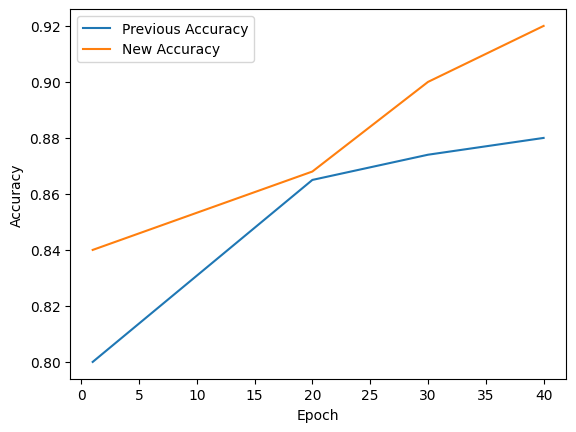

In [ ]:
#plt.plot(np.arange(len(history.history["val_accuracy"])).tolist()[:10],history.history["val_accuracy"][:10])
df_comparison=pd.DataFrame({"New Accuracy":[0.84, 0.868, 0.90,0.92],
              "old Accuracy":[0.8, 0.865, 0.874, 0.88],
              "Epoch":[1, 20, 30, 40]})
plt.plot(df_comparison["Epoch"].tolist(),df_comparison["old Accuracy"].tolist(),label = "Previous Accuracy")
plt.plot(df_comparison["Epoch"].tolist(),df_comparison["New Accuracy"].tolist(),label = "New Accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

In [ ]:
cleaned_train_data.head(40)

391     save your money by getting an oem software !  ...
4994    operating & strategic plan 2001 - 2003  one mo...
758     failure notice  hi . this is the qmail - send ...
908     mail delivery failed : returning message to se...
5657    project  hi michelle ,  chris , helen and i me...
1034    the database that bill gates doesnt want you t...
3490    re : alp presentation  dennis ,  thanks for yo...
4790    bonds  the difference is $ 4 , 391 . you can s...
3848    re : henwood query  hi karolina ,  yes , it mi...
5169    remaining work  vince ,  i shipped you the pap...
5243    risk 2000 panel discussion  dear all ,  ?  wou...
1452    e - commerce seminar 3 / 22  hi donna !  i ' l...
968     i think you might be interested  hello , i jus...
253     are you ready to get it ?  hello !  viagra is ...
2680    pro opticus  shirley ,  please , send this mem...
605     investment  attn : president ,  from : mrs . h...
5401    re : video conference  jeff ,  we have video f...
3184    info a

#Doing some statisitce on the data part 1

In [ ]:

number_of_world_spam=[len(item.split(" ")) for item in df_new[df_new["spam"]==1]["new_text"].tolist() ]
number_of_world_nospam=[len(item.split(" ")) for item in df_new[df_new["spam"]==0]["new_text"].tolist() ]

np.mean(number_of_world_spam),np.mean(number_of_world_nospam),sum(number_of_world_spam),sum(number_of_world_nospam), np.std(number_of_world_spam),np.std(number_of_world_nospam)

(288.03730797366495,
 373.46598390636433,
 393747,
 510528,
 484.20838729237425,
 381.21273599724407)

#Doing some statisitce on the data part 2

In [ ]:
number_of_sentence_spam = []
for item in df_new[df_new["spam"]==1]["new_text"].tolist():
  list1=item.split(" ")
  count = 0
  for item2 in list1:
    if item2==".":
      count +=1
  number_of_sentence_spam.append(count)

number_of_sentence_nospam = []
for item in df_new[df_new["spam"]==0]["new_text"].tolist():
  list1=item.split(" ")
  count = 0
  for item2 in list1:
    if item2==".":
      count +=1
  number_of_sentence_nospam.append(count)
np.mean(number_of_sentence_spam),np.mean(number_of_sentence_nospam),sum(number_of_sentence_spam),sum(number_of_sentence_nospam), np.std(number_of_sentence_spam),np.std(number_of_sentence_nospam)

(14.512070226773957,
 16.362106803218726,
 19838,
 22367,
 24.326382745279464,
 22.28976817457023)

In [ ]:
ddf=pd.DataFrame({"Spam Word-level":[np.mean(number_of_world_spam),sum(number_of_world_spam),np.std(number_of_world_spam)],
                  "Nospam Word-level":[np.mean(number_of_world_nospam),sum(number_of_world_nospam),np.std(number_of_world_nospam)],
                  "Spam Sentence-level":[np.mean(number_of_sentence_spam),sum(number_of_sentence_spam),np.std(number_of_sentence_spam)],
                  "Nospam Sentence-level":[np.mean(number_of_sentence_nospam),sum(number_of_sentence_nospam),np.std(number_of_sentence_nospam)]},index=["mean","count","std"])
ddf

,Spam Word-level,Nospam Word-level,Spam Sentence-level,Nospam Sentence-level
mean,288.037308,373.465984,14.512070,16.362107
count,393747.000000,510528.000000,19838.000000,22367.000000
std,484.208387,381.212736,24.326383,22.289768


from matplotlib import pyplot as plt
ddf['Spam Word-level'].plot(kind='hist', bins=20, title='Spam Word-level')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
ddf['Nospam Word-level'].plot(kind='hist', bins=20, title='Nospam Word-level')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
ddf['Spam Sentence-level'].plot(kind='hist', bins=20, title='Spam Sentence-level')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
ddf['Nospam Sentence-level'].plot(kind='hist', bins=20, title='Nospam Sentence-level')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
ddf.plot(kind='scatter', x='Spam Word-level', y='Nospam Word-level', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
ddf.plot(kind='scatter', x='Nospam Word-level', y='Spam Sentence-level', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
ddf.plot(kind='scatter', x='Spam Sentence-level', y='Nospam Sentence-level', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
ddf['Spam Word-level'].plot(kind='line', figsize=(8, 4), title='Spam Word-level')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
ddf['Nospam Word-level'].plot(kind='line', figsize=(8, 4), title='Nospam Word-level')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
ddf['Spam Sentence-level'].plot(kind='line', figsize=(8, 4), title='Spam Sentence-level')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
ddf['Nospam Sentence-level'].plot(kind='line', figsize=(8, 4), title='Nospam Sentence-level')
plt.gca().spines[['top', 'right']].set_visible(False)

#Just visualize non-spam data

In [ ]:
df_new[df_new["spam"]==0]

,text,spam,new_text
2859,"Subject: boss ' s day hey everyone , i know ...",0,"boss ' s day hey everyone , i know you may n..."
5494,"Subject: enron media / advertising simon , p...",0,"enron media / advertising simon , please for..."
3026,Subject: congratulations vince : congratulati...,0,congratulations vince : congratulations on yo...
4267,Subject: interview candidate allen humbolt de...,0,interview candidate allen humbolt dear elizab...
3603,"Subject: your advice is appreciated vince , ...",0,"your advice is appreciated vince , in the mo..."
...,...,...,...
1757,"Subject: re : anshuman neil , you must have ...",0,"re : anshuman neil , you must have already g..."
2920,Subject: re : 2001 headcount information dawn...,0,re : 2001 headcount information dawn : i am ...
5184,"Subject: re : enron / stanford program nick ,...",0,"re : enron / stanford program nick , dinner ..."
4991,"Subject: re : subscriptions stephanie , plea...",0,"re : subscriptions stephanie , please , disc..."


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [ ]:
df_new[df_new["spam"]==0]["new_text"]

2475    re : f / u to dr . kaminski @ enron from iris ...
5027    re : mba polish speakers  does he know any of ...
4885    re : action learning project and enron tour  h...
5566    re : mgmt 656 ( rice university )  this list i...
4354    re : prospective 6 / 22 houston visit  ehud , ...
                              ...                        
4577    meetings with petronas on february 8 th  good ...
4799    re : workshop  helyette ,  i shall be glad to ...
3357    aiesec  vince ,  my name is shelly jones , i a...
1459    uk rpi model  hi zimin !  please find attached...
1482    videoconferencing picture clears up  network w...
Name: new_text, Length: 1367, dtype: object

#pick up one sample spam data and test model on it

In [ ]:
import numpy as np

In [ ]:
element_at_index_10=df_new[df_new["spam"]==1]["new_text"].iloc[200]
new_series = pd.Series([element_at_index_10])
element_at_index_10

"we dare you to find a better annuity  call today for more information !  - or -  please fill out the form below for more information  name :  e - mail :  phone :  city :  state :  * 5 . 40 % for deposits of $ 100 , 000 and up , 5 . 25 % interest for deposits totalling $ 25 , 000 - $ 99 , 999 .  we  don ' t want anyone to receive our mailings who does not  wish to receive them . this is a professional communication  sent to insurance professionals . to be removed from this mailing  list , do not reply to this message . instead , go here :  http : / / www . insuranceiq . com / optout  legal notice "

In [ ]:
np.round(model.predict(new_series))[0]

1/1 [==============================] - 0s 190ms/step


array([1.], dtype=float32)

#Pick up one non-spam data and visualize it

In [ ]:
element_at_index=df_new[df_new["spam"]==0]["new_text"].iloc[50]
new_series = pd.Series([element_at_index])
element_at_index

're : agenda for houston visit  christian ,  good news  vince has approved getting a corporate apartment for your stay  please forward your finalized arrival date and extent of stay and i will  coordinate  - - - mike'

In [ ]:
np.round(model.predict(new_series))[0]

1/1 [==============================] - 0s 198ms/step


array([0.], dtype=float32)

In [ ]:
import os
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorboard.plugins import projector

#Adding data to list_sentence for visualizing data in higher space

In [ ]:
#Adding data to list_sentence
list_sentence= []
for item in df_new[df_new["spam"]==1]["new_text"].tolist():
  list1=item.split(" ")
  #print(list1)
  list_sentence.extend(list1)
  count = 0
  for item2 in list1:
    if item2==".":
      count +=1
  number_of_sentence_spam.append(count)

for item in df_new[df_new["spam"]==0]["new_text"].tolist():
  list1=item.split(" ")
  #print(list1)
  list_sentence.extend(list1)

#Set up the tensor board to visual the data in higher domensional Embedding Space

In [ ]:

log_dir='/logs/imdb-example/'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# Save Labels separately on a line-by-line manner.
with open(os.path.join(log_dir, 'metadata.tsv'), "w") as f:
  for subwords in list_sentence: #encoder.subwords:
    f.write("{}\n".format(subwords))
  # Fill in the rest of the labels with "unknown"

# Save the weights we want to analyze as a variable. Note that the first
# value represents any unknown word, which is not in the metadata, here
# we will remove this value.
weights = tf.Variable(model.layers[2].get_weights()[0][1:])
# Create a checkpoint from embedding, the filename and key are the
# name of the tensor.
checkpoint = tf.train.Checkpoint(embedding=weights)
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

# Set up config.
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
# The name of the tensor will be suffixed by `/.ATTRIBUTES/VARIABLE_VALUE`.
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv'
projector.visualize_embeddings(log_dir, config)

In [ ]:
%tensorboard --logdir /logs/imdb-example/


In [ ]:
#Saving model
model.save("/content/Bigdata_Bert.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
